In [ ]:
import os
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
from pyspark.sql.functions import col, current_timestamp, to_date, hour, dayofweek

import numpy as np

from itertools import combinations

In [ ]:
def create_new_spark_context(appName):
    return SparkSession.builder.appName(appName)\
        .master("local[*]").getOrCreate()


spark_session = create_new_spark_context("LSH")
sc = spark_session.sparkContext


In [ ]:
schema = StructType([
    StructField("DEVICE_CODE", IntegerType(), True),
    StructField("SYSTEM_ID", IntegerType(), True),
    StructField("ORIGINE_CAR_KEY", StringType(), True),
    StructField("FINAL_CAR_KEY", StringType(), True),
    StructField("CHECK_STATUS_KEY", IntegerType(), True),
    StructField("COMPANY_ID", StringType(), True),
    StructField("PASS_DAY_TIME", TimestampType(), True)
])

In [ ]:
df = spark_session.read.csv(
    '/content/drive/MyDrive/MDA/Project/TrafficData.csv', header=True, schema=schema)


First we remove the outliers from the data. Namely the cars that have been recorded more than 1000 times. We can do this by using the following code:

In [ ]:
# add count column to count the number of records, group by FINAL_CAR_KEY
# define a window to count the number of records for each car

from pyspark.sql.window import Window
from pyspark.sql.functions import count

window = Window.partitionBy("FINAL_CAR_KEY")
df = df.withColumn("COUNT", count("*").over(window))

# remove cars with moe than 1000 records
df = df.filter(col("COUNT") < 1000)
df.show(5)


+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|COUNT|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
|   22010053|      284|       10000007|     10000007|               5|       161|2022-01-12 06:30:27|    1|
|     900233|      283|       10000016|     10000016|               5|       264|2022-01-14 13:57:13|    1|
|     900242|      283|       10000048|     10000048|               5|       264|2022-01-09 21:58:56|    9|
|     101301|       81|       10000048|     10000048|               5|       161|2022-01-09 21:54:31|    9|
|        135|       81|       10000048|     10000048|               5|       161|2022-01-09 21:36:46|    9|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
only showing top 5 rows



Now We filter the cars that have been recorded frequently. For example, those recorded more than 100 times. We can do this by using the following code:

In [ ]:
# remove cars with less than 100 records
df = df.filter(col("COUNT") > 100)

## Pixie

First we consider the case where we just want to consider a specific hour of the week. Here I wont apply a filter on the hour because it doesn't make deference in the implementation. Let's Create an RDD with the following format: (FINAL_CAR_KEY, DEVICE_CODE)

In [ ]:
car_device_rdd = df.rdd.map(lambda x: (x['FINAL_CAR_KEY'], x['DEVICE_CODE']))


In [ ]:
# create 2 rdds, one for cars, one for cameras. representing the edges going out of each car and camera
# the rdds are the adjacency list of the graph

car_rdd = car_device_rdd.map(lambda x: (x[0], x[1])).groupByKey().mapValues(list).sortByKey()
device_rdd = car_device_rdd.map(lambda x: (x[1], x[0])).groupByKey().mapValues(list).sortByKey()

In [ ]:
NUM_CAR = car_rdd.count()
NUM_CAMERA = device_rdd.count()


Now we implement the Pixie algorithm for both queries from cars and from devices. In the code below we use the following parameters:

* **MAX_ITER**: The maximum number of iterations for the algorithm
* **alpha**: The probability of sampling an edge from the the original query set

We have also added early stopping and weighted sampling to the algorithm.

In [ ]:
# pixie algorithm

import os
MAX_ITER = 1000

# disable the randomness of hash of the string via PYTHONHASHSEED
os.environ['PYTHONHASHSEED'] = str(1)


def pixie_car(car, device, stop_threshold=20, alpha=0.5):
    scores = {}
    current_car = car
    current_device = device
    for i in range(MAX_ITER):
        current_device = np.random.choice(car_rdd.lookup(current_car)[0])
        current_car = np.random.choice(device_rdd.lookup(current_device)[0])
        
        if current_car in scores:
            scores[current_car] += 1
        else:
            scores[current_car] = 1
            
        if np.random.random() < alpha:
            current_car = car
            
        if any(x > stop_threshold for x in scores.values()):
            return scores
            
    return scores


def pixie_device(device, car, stop_threshold=20, alpha=0.5):
    scores = {}
    current_car = car
    current_device = device
    for i in range(MAX_ITER):
        current_car = np.random.choice(device_rdd.lookup(current_device)[0])
        current_device = np.random.choice(car_rdd.lookup(current_car)[0])
        
        if current_device in scores:
            scores[current_device] += 1
        else:
            scores[current_device] = 1
            
        if np.random.random() < alpha:
            current_device = device
            
        if any(x > stop_threshold for x in scores.values()):
            return scores
            
    return scores


Here we make a query.

In [ ]:
query = car_device_rdd.takeSample(False, 1)[0]
query_car = query[0]
query_device = query[1]

relevant_devices = pixie_device(query_device, query_car)

In [ ]:
query

('73257028', 100700853)

In [ ]:
# get top k relevant items by score

def get_top_k(scores, k):
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]


top_k_devices = get_top_k(relevant_devices, 10)

Here we plot the results for the query from devices and cars. The x-axis is each car or device and the y-axis is the number of times it has been visited by the query, or the pixie score.

In [ ]:
# define plot function
import matplotlib.pyplot as plt
import numpy as np


def plot_bar(scores, title, x_label, y_label, figsize=(40, 20), color='blue'):

    plt.figure(figsize=figsize)
    plt.bar(np.arange(len(scores)), [x[1] for x in scores], 
            align="center", alpha=0.5, color=color, edgecolor="black", linewidth=1, width=0.7)
    plt.xticks(np.arange(len(scores)), [x[0] for x in scores])
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

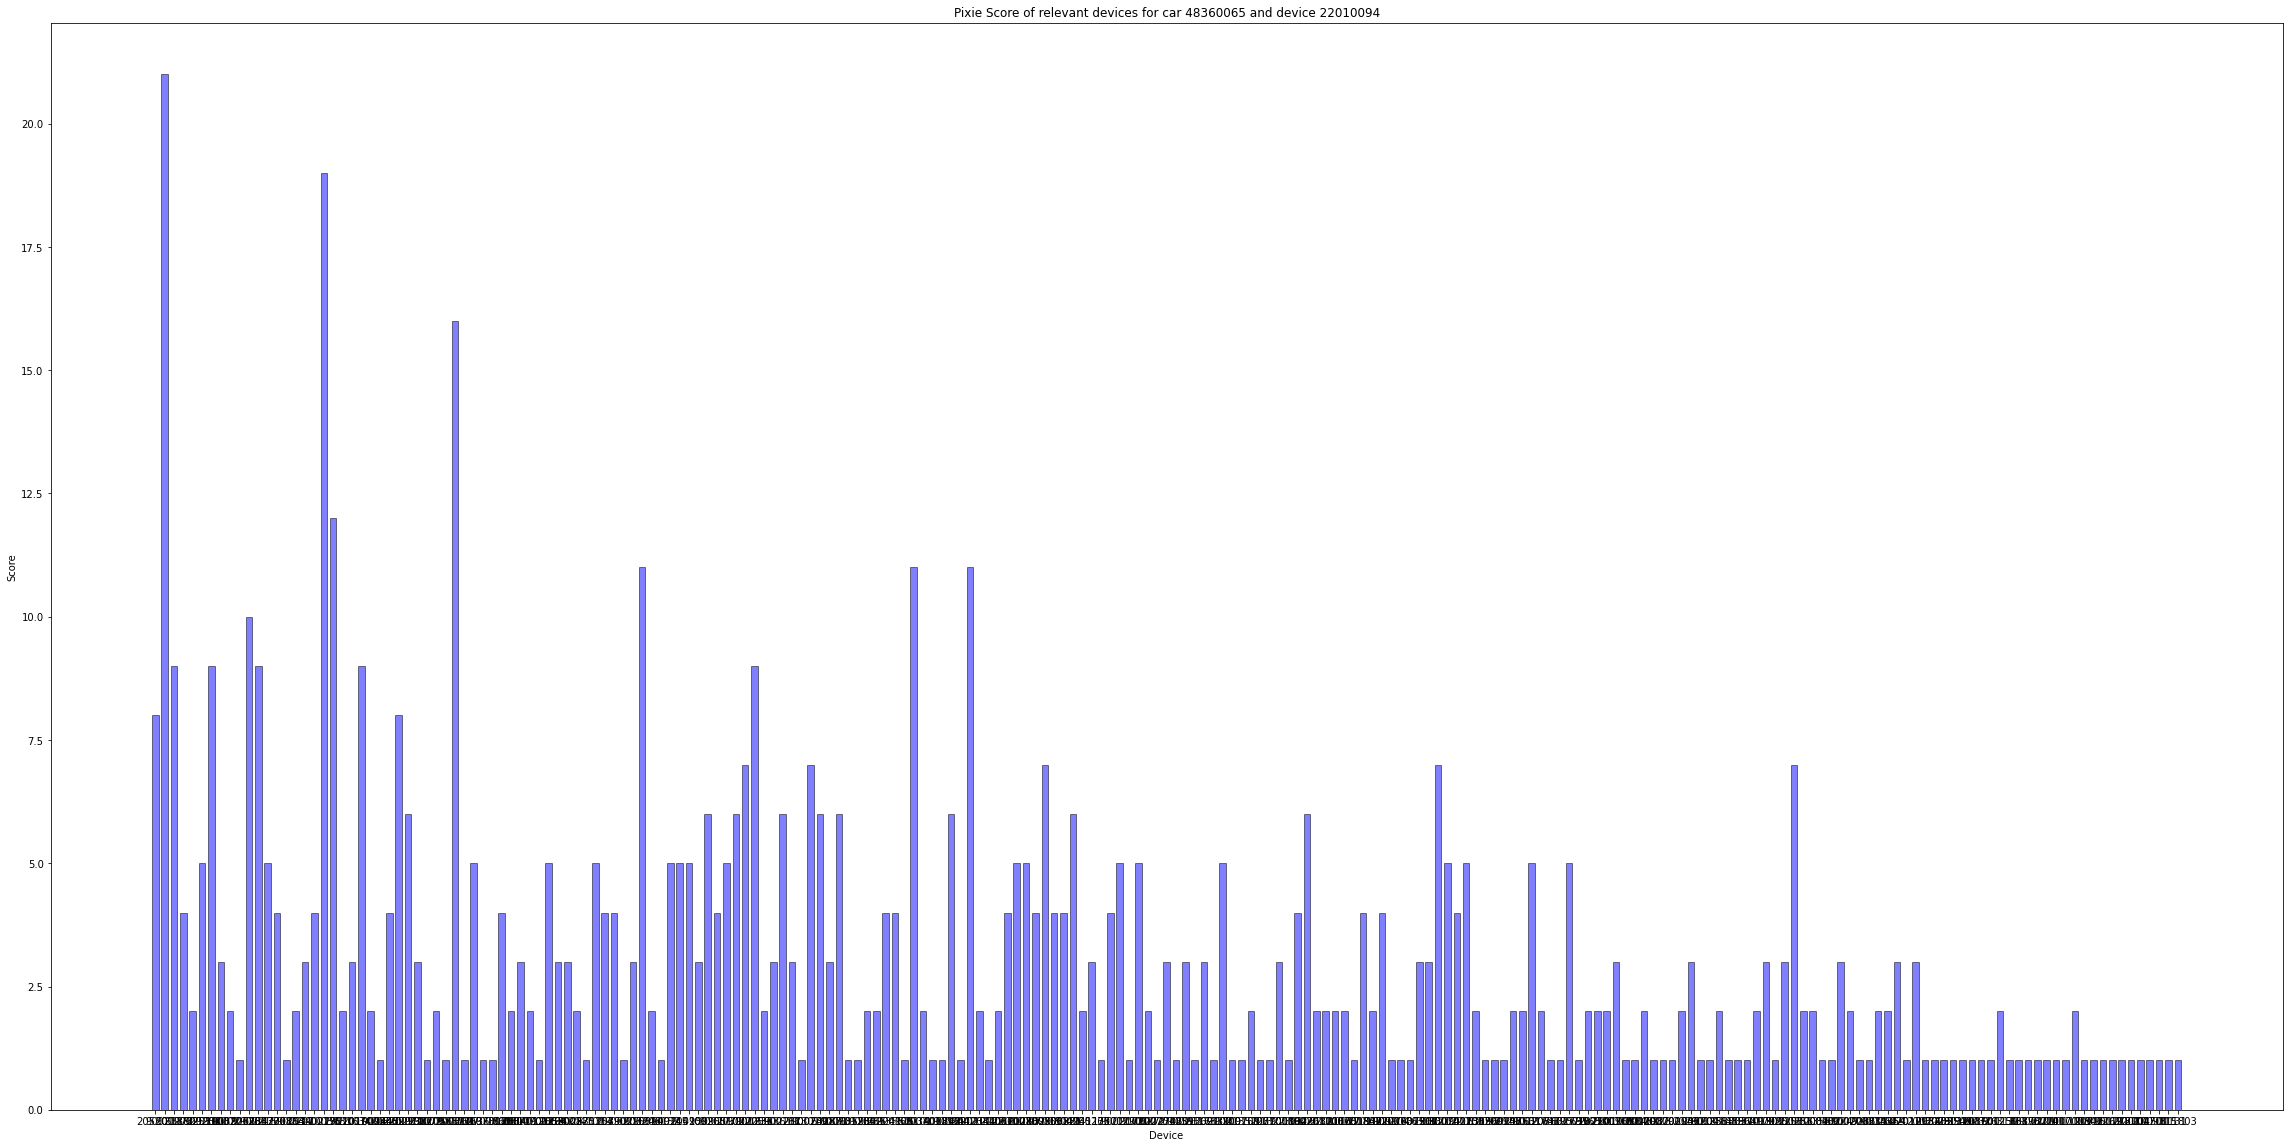

In [ ]:
# plot the results

# convert dict to list of tuples
relevant_devices_list = list(relevant_devices.items())

plot_bar(relevant_devices_list, "Pixie Score of relevant devices for car " +
         query_car + " and device " + str(query_device), "Device", "Score")


Now we make a query from cars.

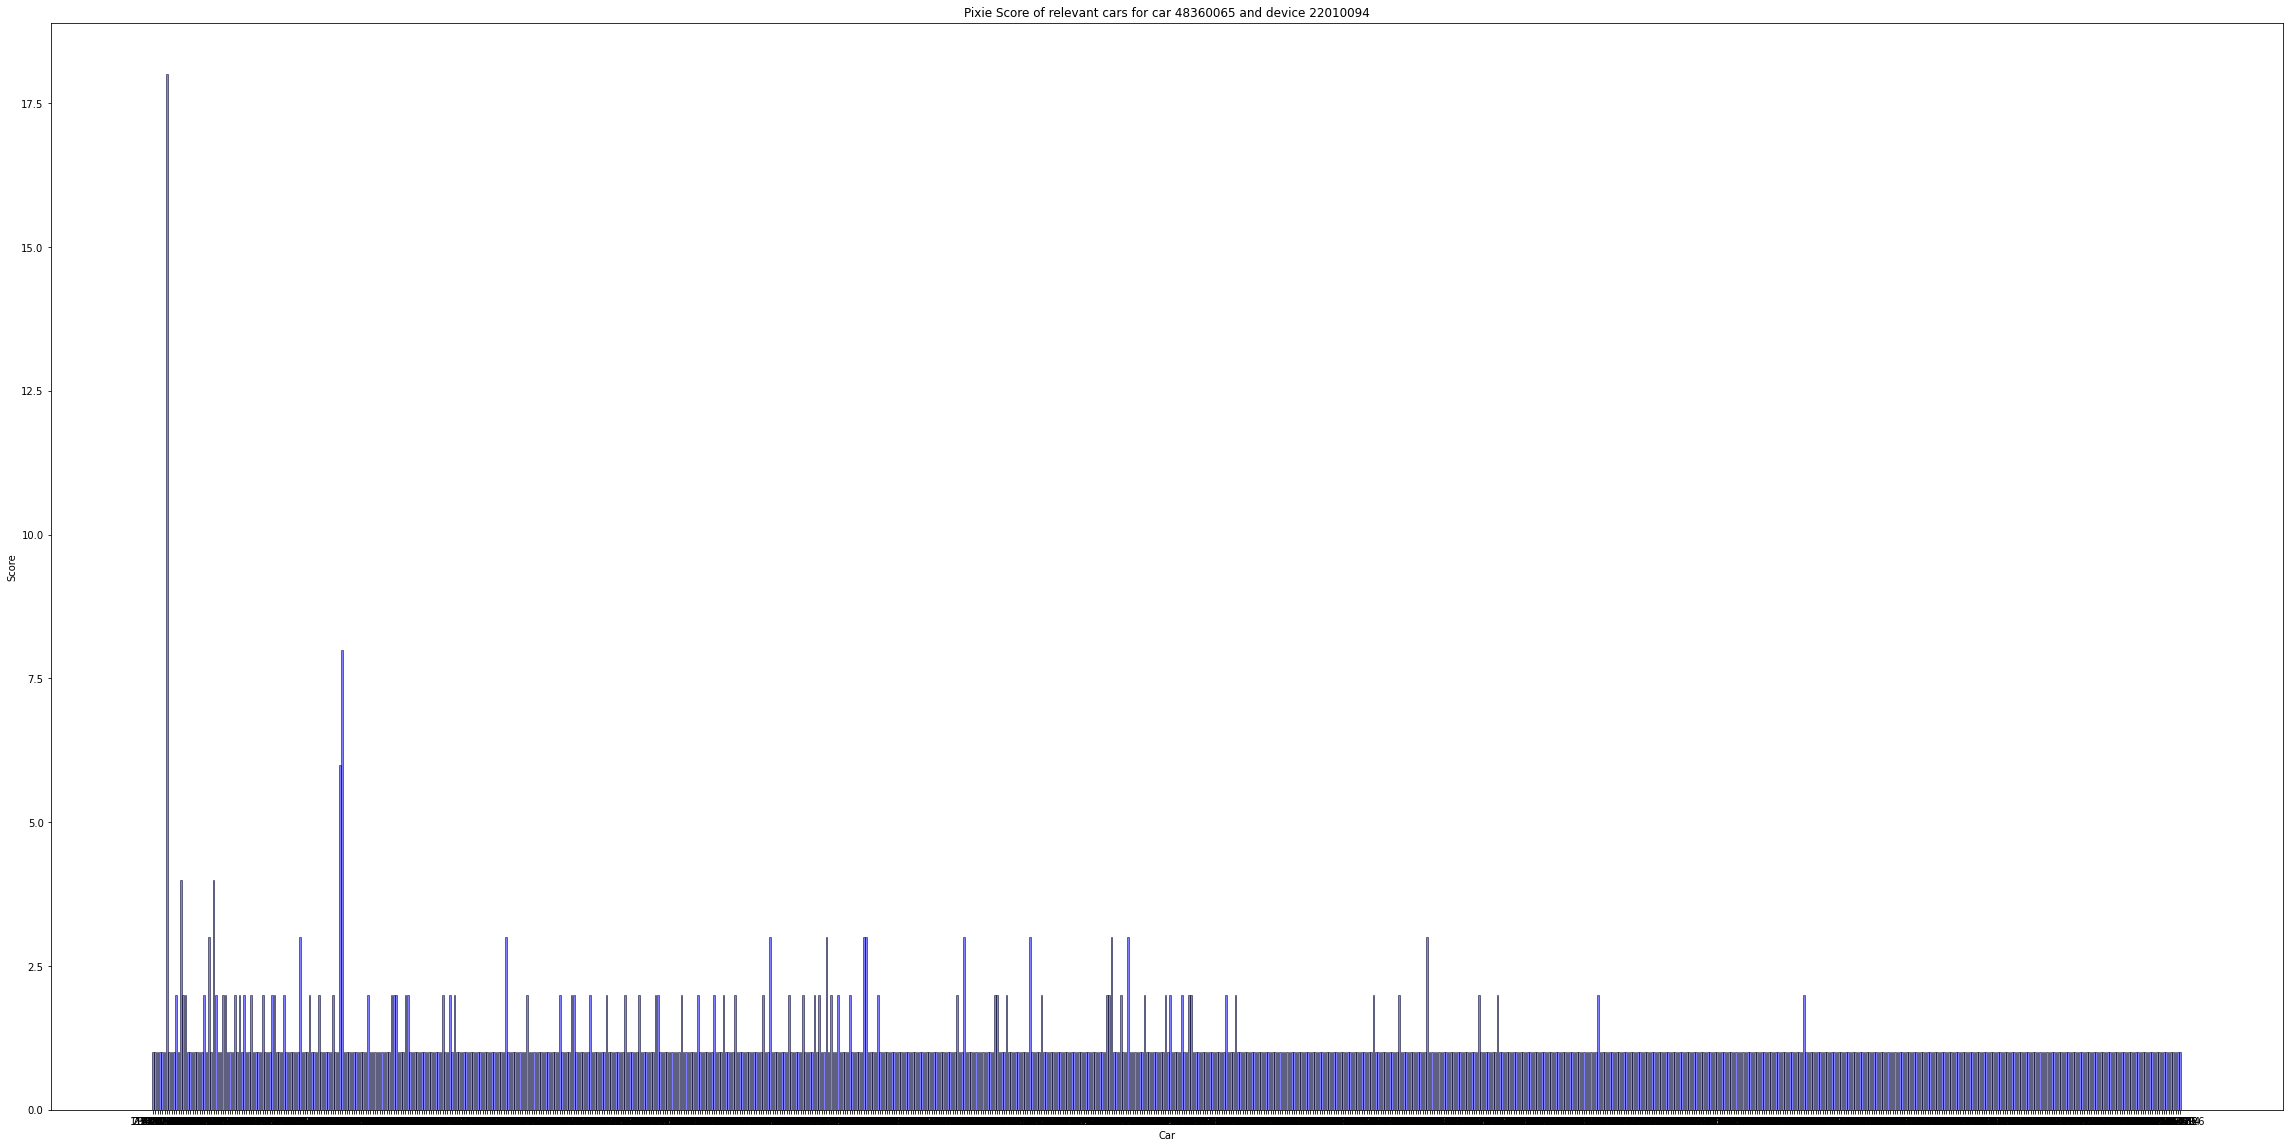

In [ ]:
# query from the other direction

relevant_cars = pixie_car(query_car, query_device)
top_k_cars = get_top_k(relevant_cars, 10)

# convert dict to list of tuples
relevant_cars_list = list(relevant_cars.items())

plot_bar(relevant_cars_list, "Pixie Score of relevant cars for car " +
            query_car + " and device " + str(query_device), "Car", "Score")

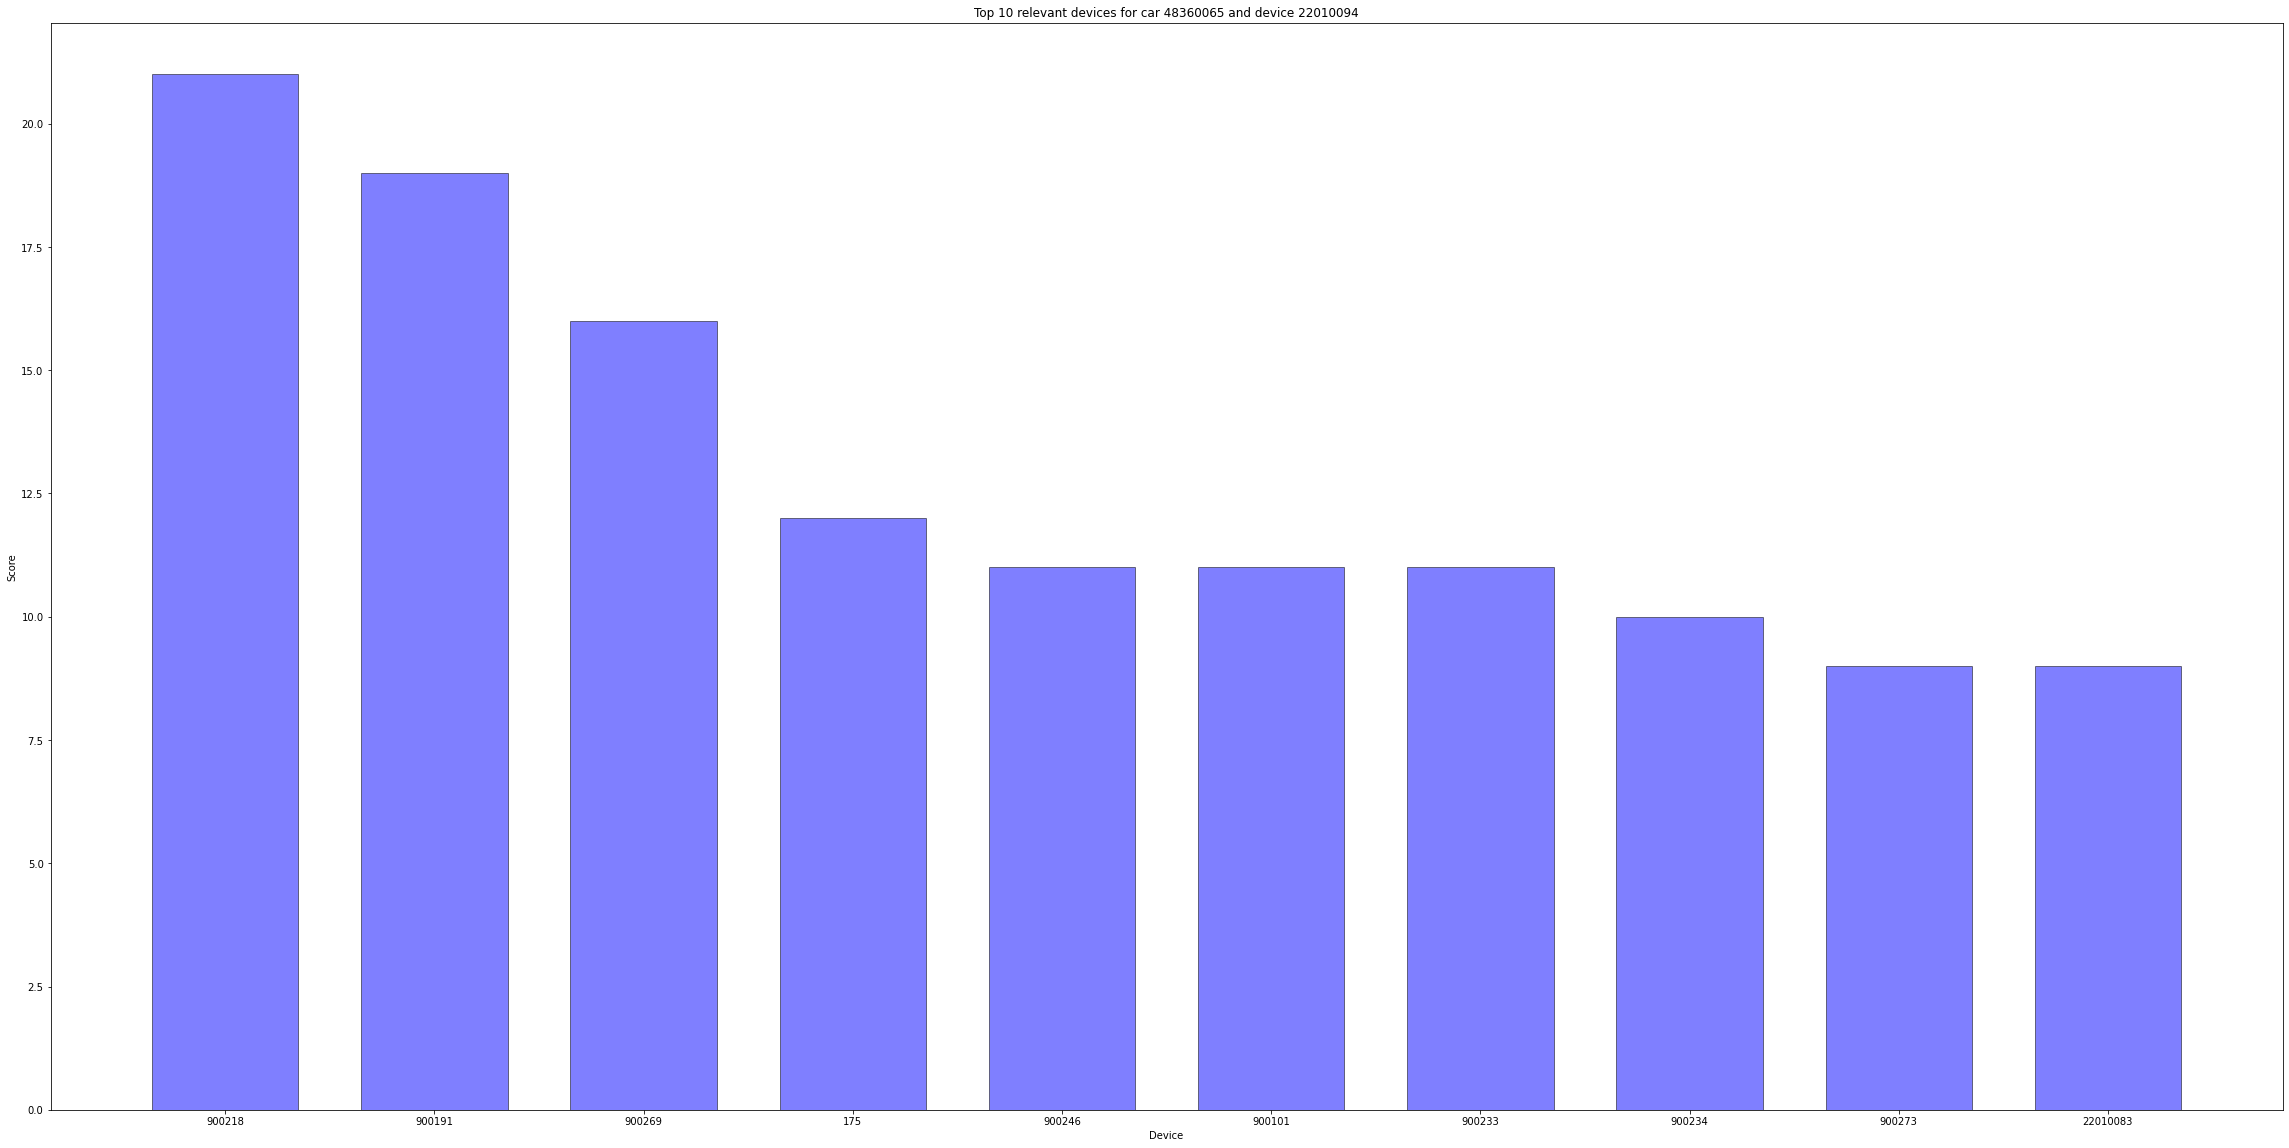

In [ ]:
plot_bar(top_k_devices, "Top 10 relevant devices for car " +
         query_car + " and device " + str(query_device), "Device", "Score")

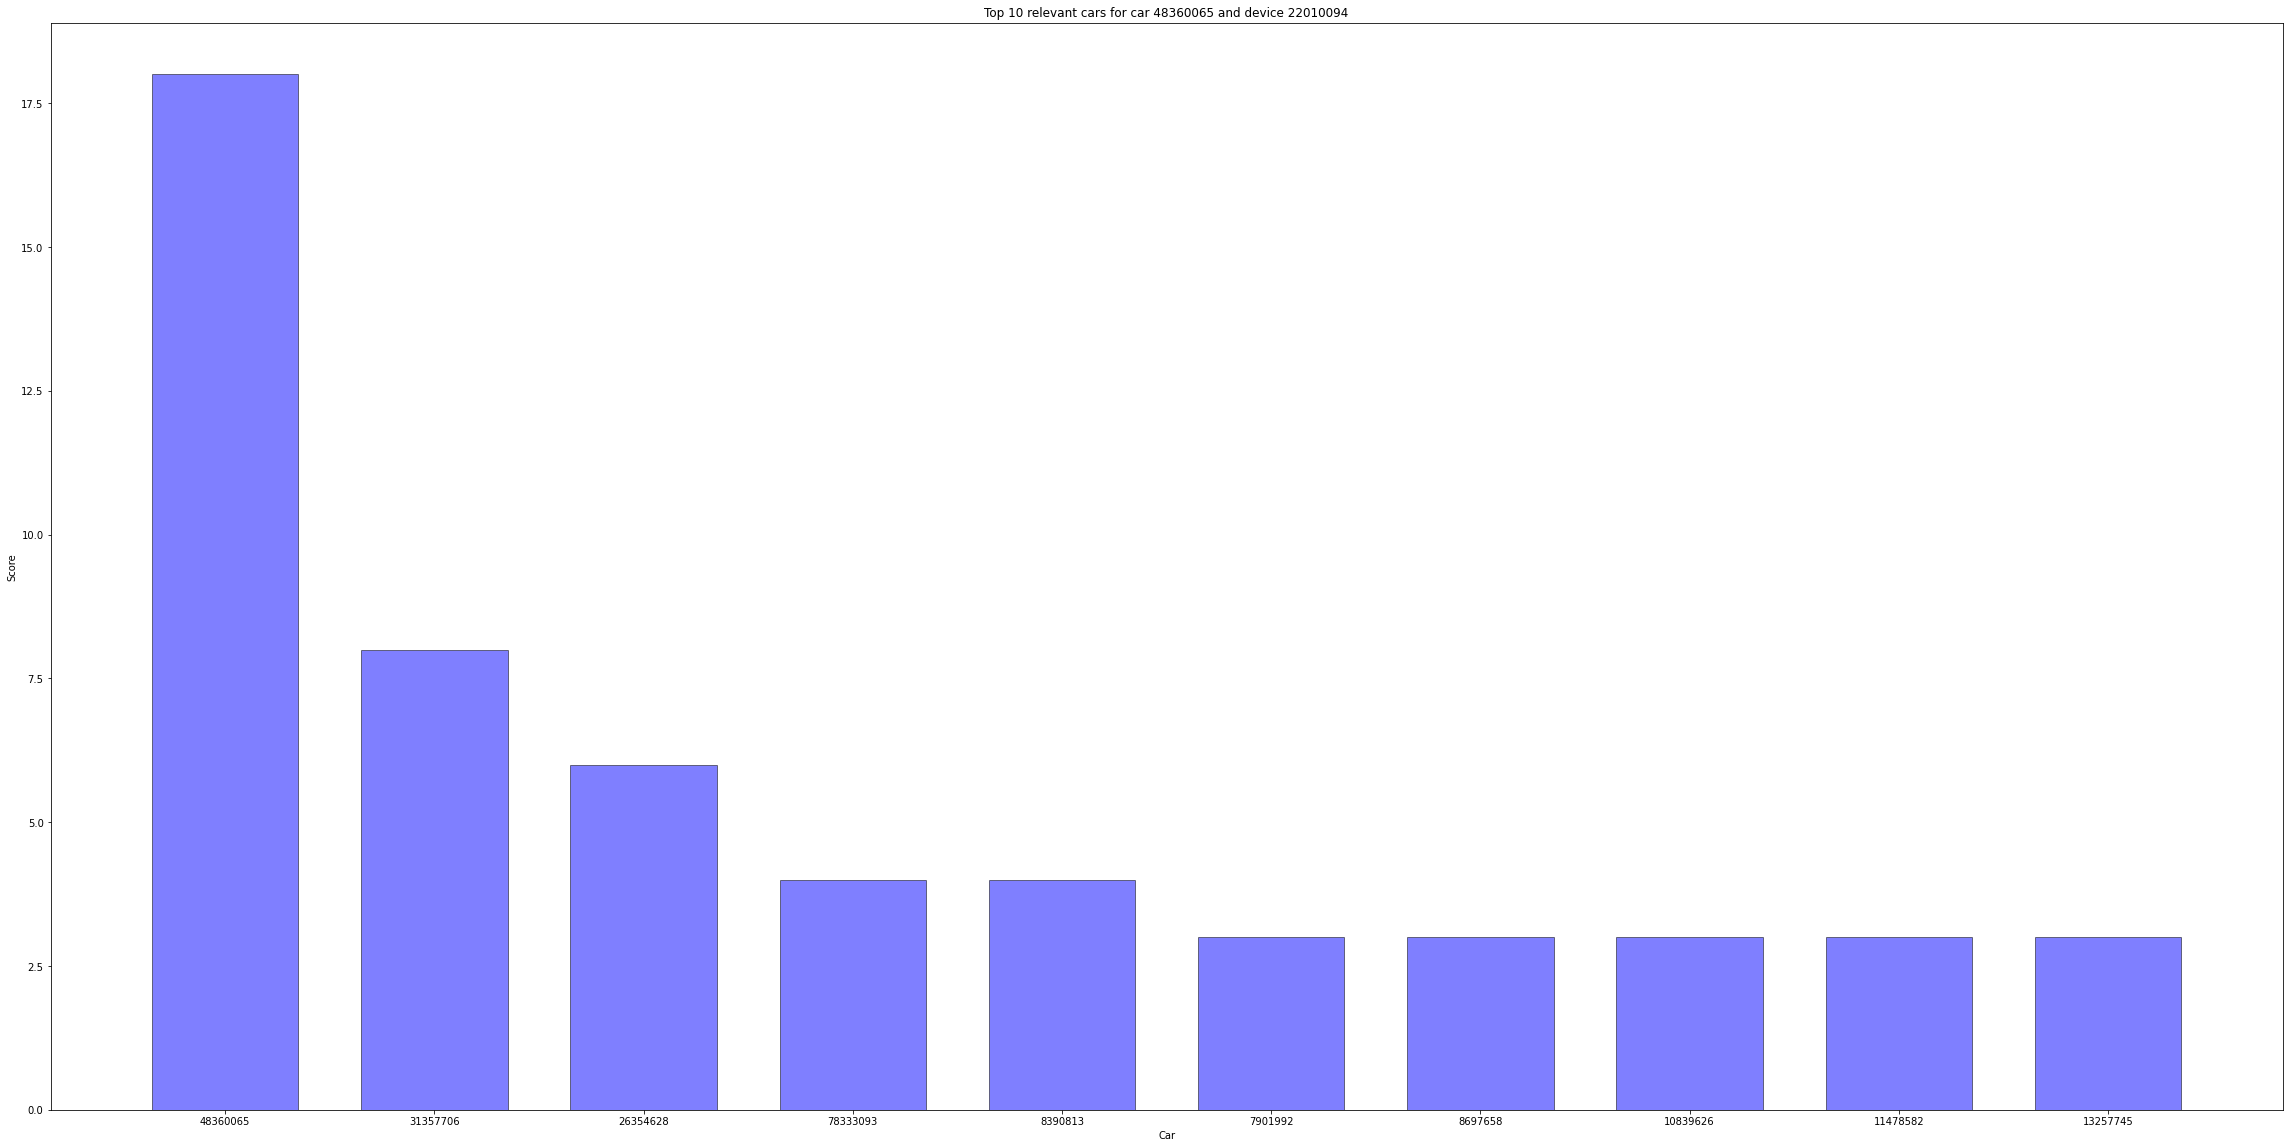

In [ ]:
plot_bar(top_k_cars, "Top 10 relevant cars for car " +
            query_car + " and device " + str(query_device), "Car", "Score")

In [ ]:
top_k_devices = set([x[0] for x in top_k_devices])

In [ ]:
top_devices_info = df.rdd.filter(lambda x: x[0] in top_k_devices).collect()
# get type of device
top_devices_info = {x[1] for x in top_devices_info}
top_devices_info

{81, 282, 283}

Secondly we implement the Pixie algorithm considering the hours of the week. First we create an RDD with the following format: (FINAL_CAR_KEY, DEVICE_CODE, HOUR_OF_WEEK)

In [ ]:
# add HOUR_OF_WEEK column

from pyspark.sql.functions import hour, dayofweek, col

df = df.withColumn("HOUR_OF_WEEK", (dayofweek(col("PASS_DAY_TIME")) - 1) * 24 + hour(col("PASS_DAY_TIME")))        
car_device_hour_rdd = df.rdd.map(lambda x: (x['FINAL_CAR_KEY'], x['DEVICE_CODE'], x['HOUR_OF_WEEK']))

Now we create the bipartite graph the same way as previous part.

In [ ]:
car_hour_rdd = car_device_hour_rdd.map(lambda x: (x[0], (x[1], x[2]))).groupByKey().mapValues(list).sortByKey()
device_hour_rdd = car_device_hour_rdd.map(lambda x: (x[1], (x[0], x[2]))).groupByKey().mapValues(list).sortByKey()

In [ ]:
# pixie algorithm

MAX_ITER = 1000


def pixie_car_with_hour(hour, car, device, stop_threshold=20, alpha=0.5):
    scores = {}
    current_car = car
    current_device = device
    for i in range(MAX_ITER):
        neighbor_devices = car_hour_rdd.lookup(current_car)[0]
        # filter devices that have not recorded at the given time
        neighbor_devices = [x[0] for x in neighbor_devices if hour == x[1]]
        current_device = np.random.choice(neighbor_devices)
        
        neighbor_cars = device_hour_rdd.lookup(current_device)[0]
        # filter cars that have not recorded at the given time
        neighbor_cars = [x[0] for x in neighbor_cars if hour == x[1]]
        current_car = np.random.choice(neighbor_cars)

        if current_car in scores:
            scores[current_car] += 1
        else:
            scores[current_car] = 1

        if np.random.random() < alpha:
            current_car = car

        if any(x > stop_threshold for x in scores.values()):
            return scores

    return scores


def pixie_device_with_hour(hour, device, car, stop_threshold=20, alpha=0.5):
    scores = {}
    current_car = car
    current_device = device
    for i in range(MAX_ITER):
        neighbor_cars = device_hour_rdd.lookup(current_device)[0]
        # filter cars that have not recorded at the given time
        neighbor_cars = [x[0] for x in neighbor_cars if hour == x[1]]
        current_car = np.random.choice(neighbor_cars)
        
        neighbor_devices = car_hour_rdd.lookup(current_car)[0]
        # filter devices that have not recorded at the given time
        neighbor_devices = [x[0] for x in neighbor_devices if hour == x[1]]
        current_device = np.random.choice(neighbor_devices)

        if current_device in scores:
            scores[current_device] += 1
        else:
            scores[current_device] = 1

        if np.random.random() < alpha:
            current_device = device

        if any(x > stop_threshold for x in scores.values()):
            return scores

    return scores


Now we take a sample from the __car_device_hour__ RDD to use as the query.

In [ ]:
query = car_device_hour_rdd.takeSample(False, 1)[0]
query_car = query[0]
query_device = query[1]
query_hour = query[2]

In [ ]:
query

('17741680', 631831, 7)

In [ ]:
relevant_devices = pixie_device_with_hour(query_hour, query_device, query_car)
relevant_cars = pixie_car_with_hour(query_hour, query_car, query_device)

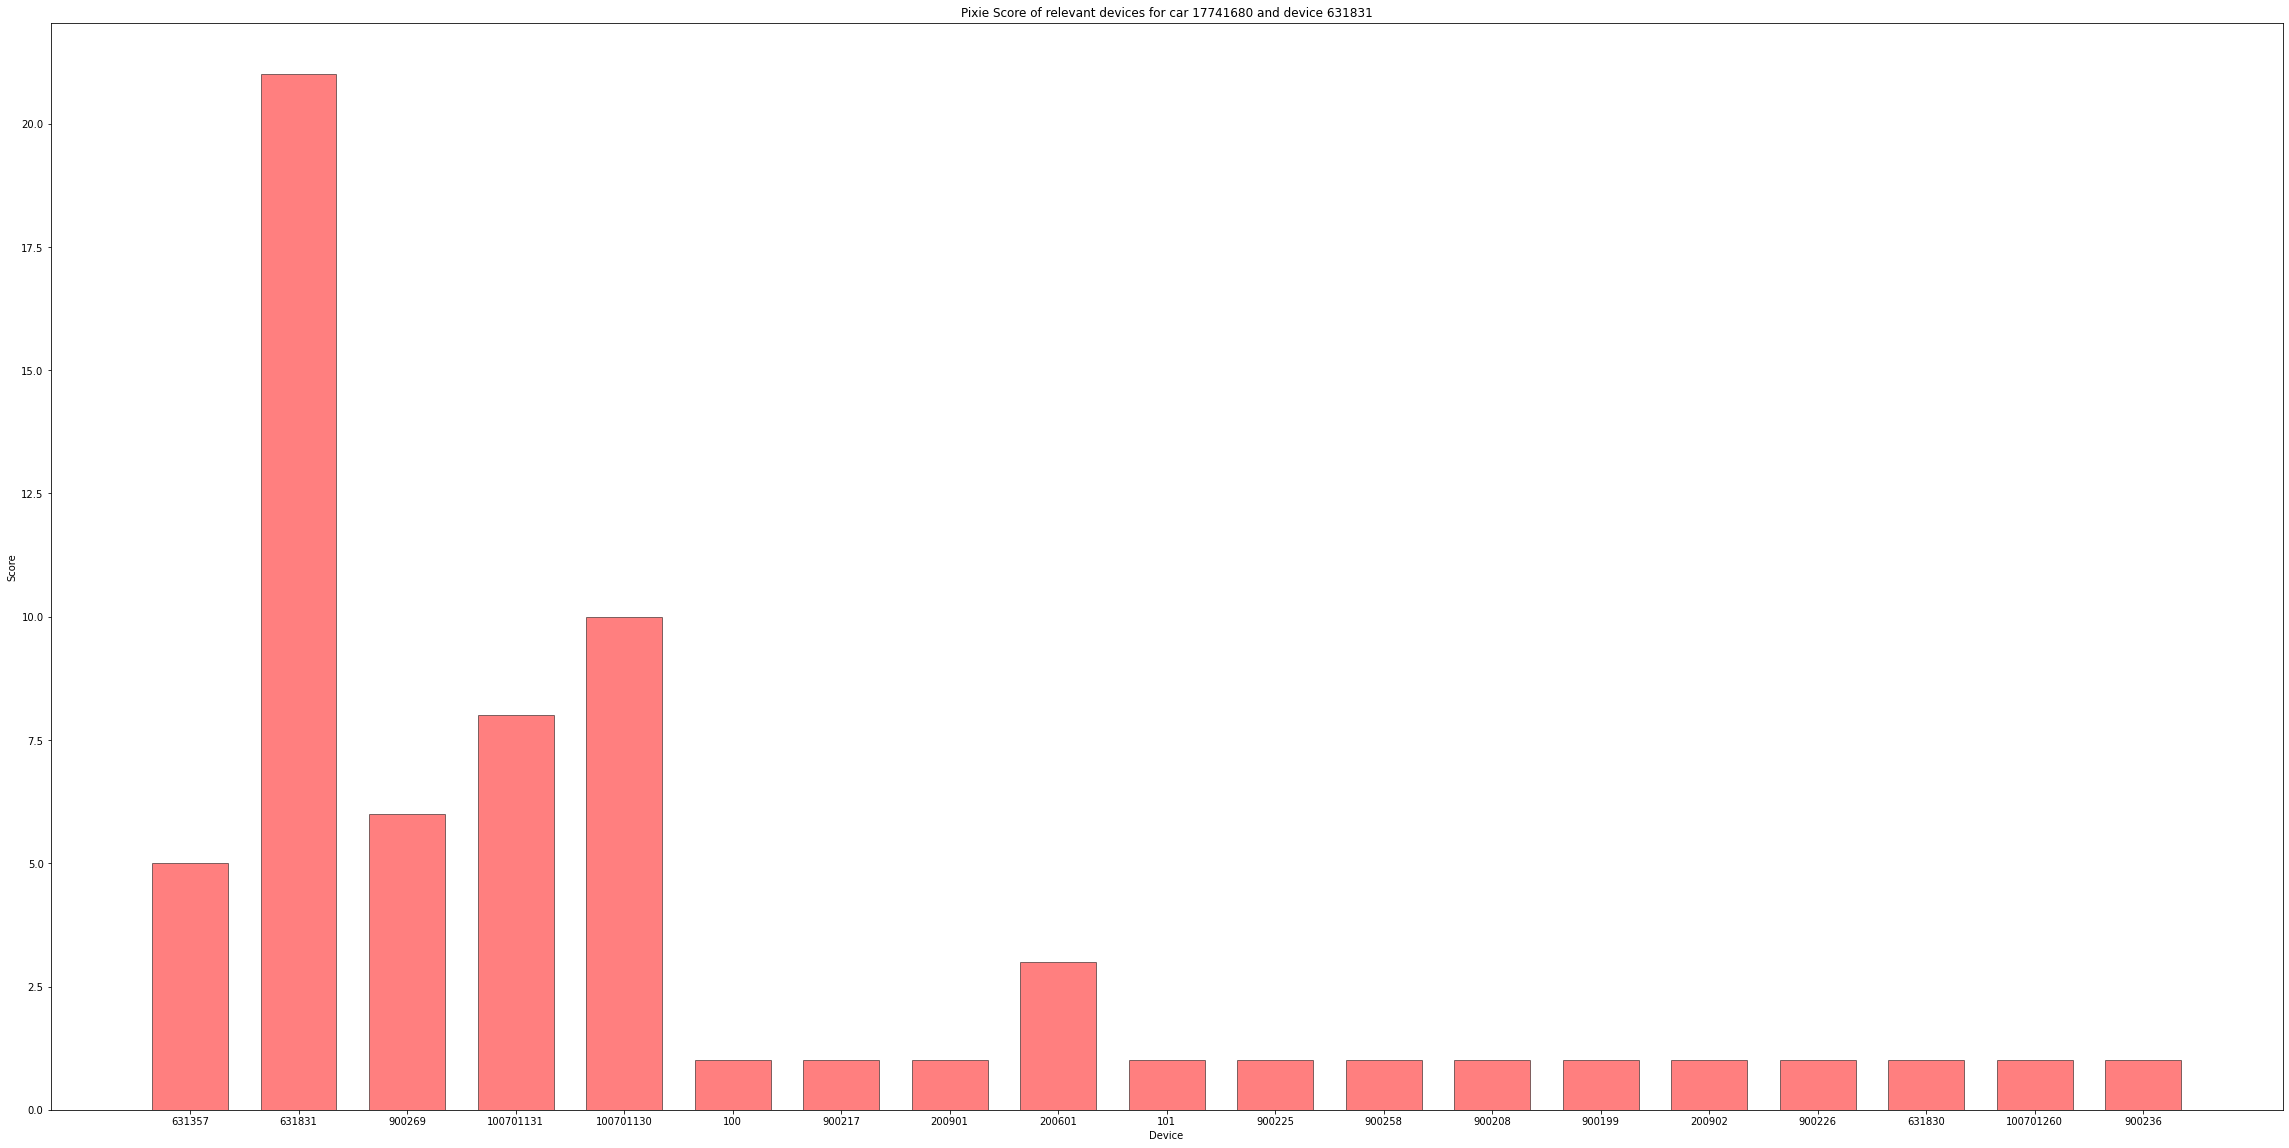

In [ ]:
top_k_devices = get_top_k(relevant_devices, 10)

# convert dict to list of tuples
relevant_devices_list = list(relevant_devices.items())



plot_bar(relevant_devices_list, "Pixie Score of relevant devices for car " +
         query_car + " and device " + str(query_device), "Device", "Score", color='red')

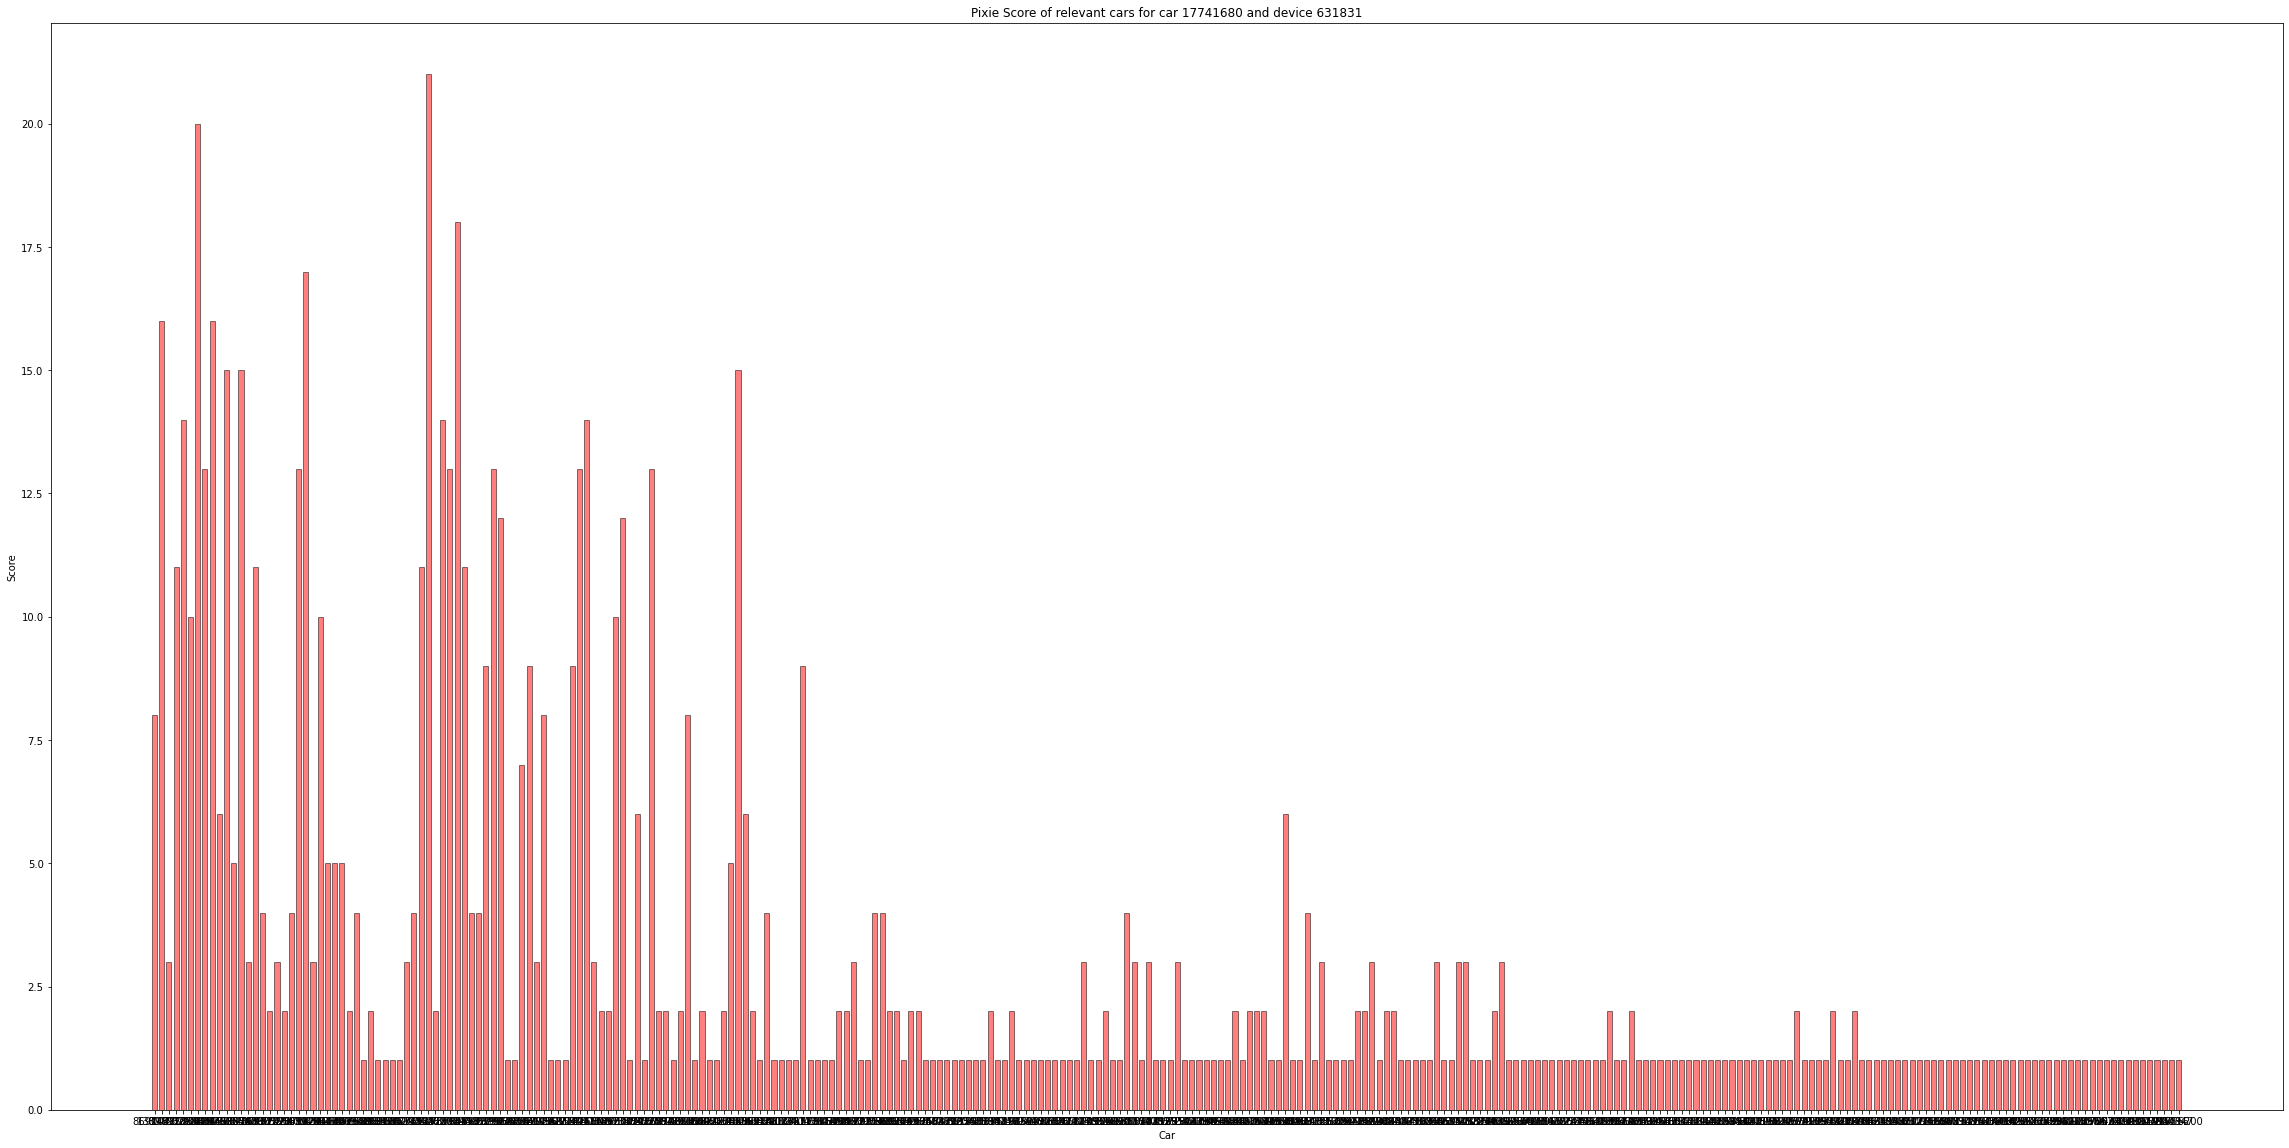

In [ ]:
top_k_cars = get_top_k(relevant_cars, 10)

# convert dict to list of tuples
relevant_cars_list = list(relevant_cars.items())

plot_bar(relevant_cars_list, "Pixie Score of relevant cars for car " +
         query_car + " and device " + str(query_device), "Car", "Score", color='red')


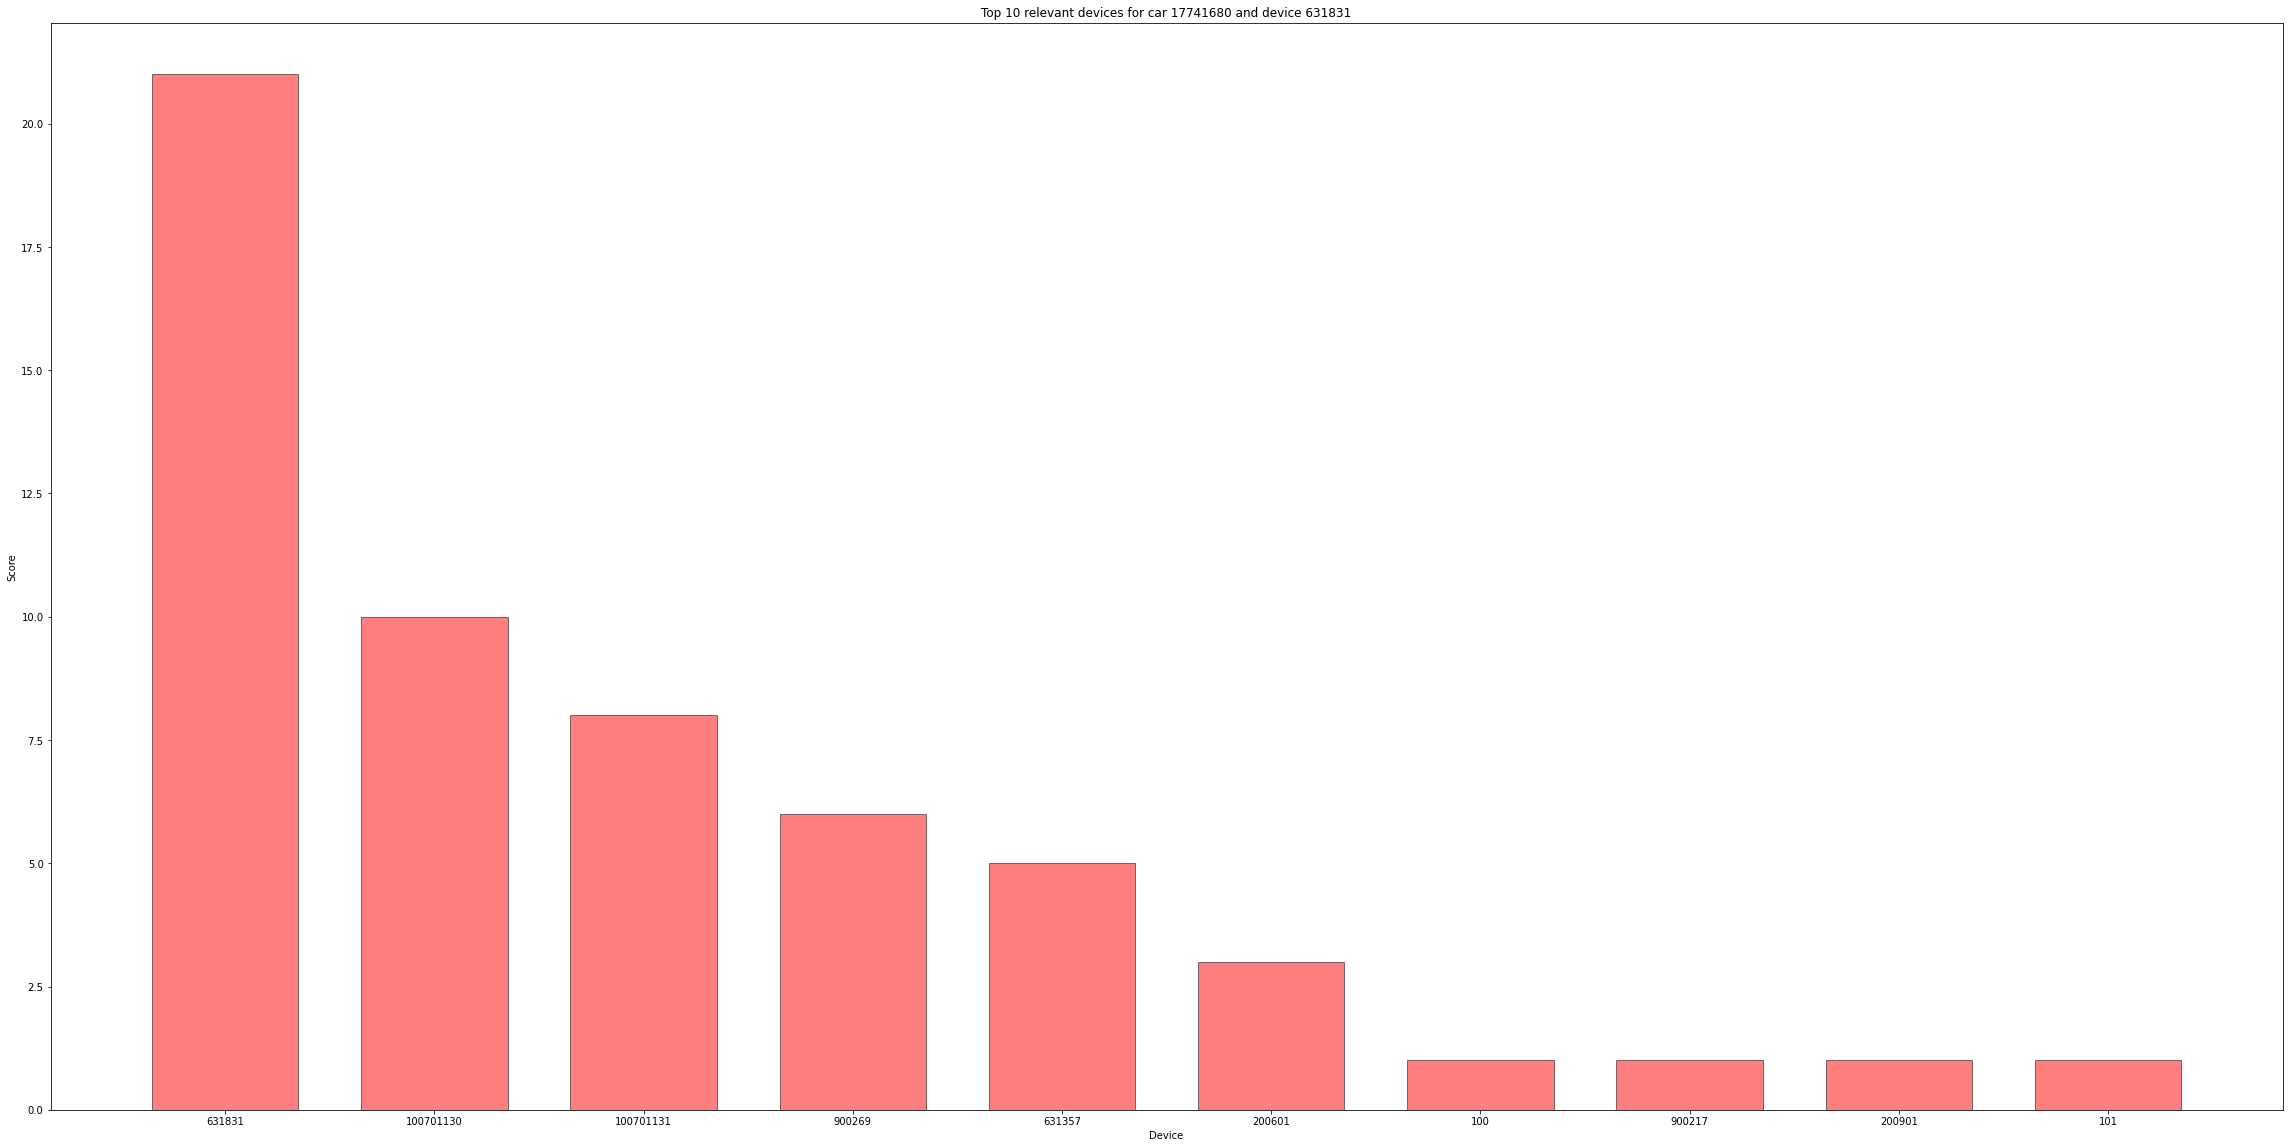

In [ ]:
plot_bar(top_k_devices, "Top 10 relevant devices for car " +
         query_car + " and device " + str(query_device), "Device", "Score", color='red')

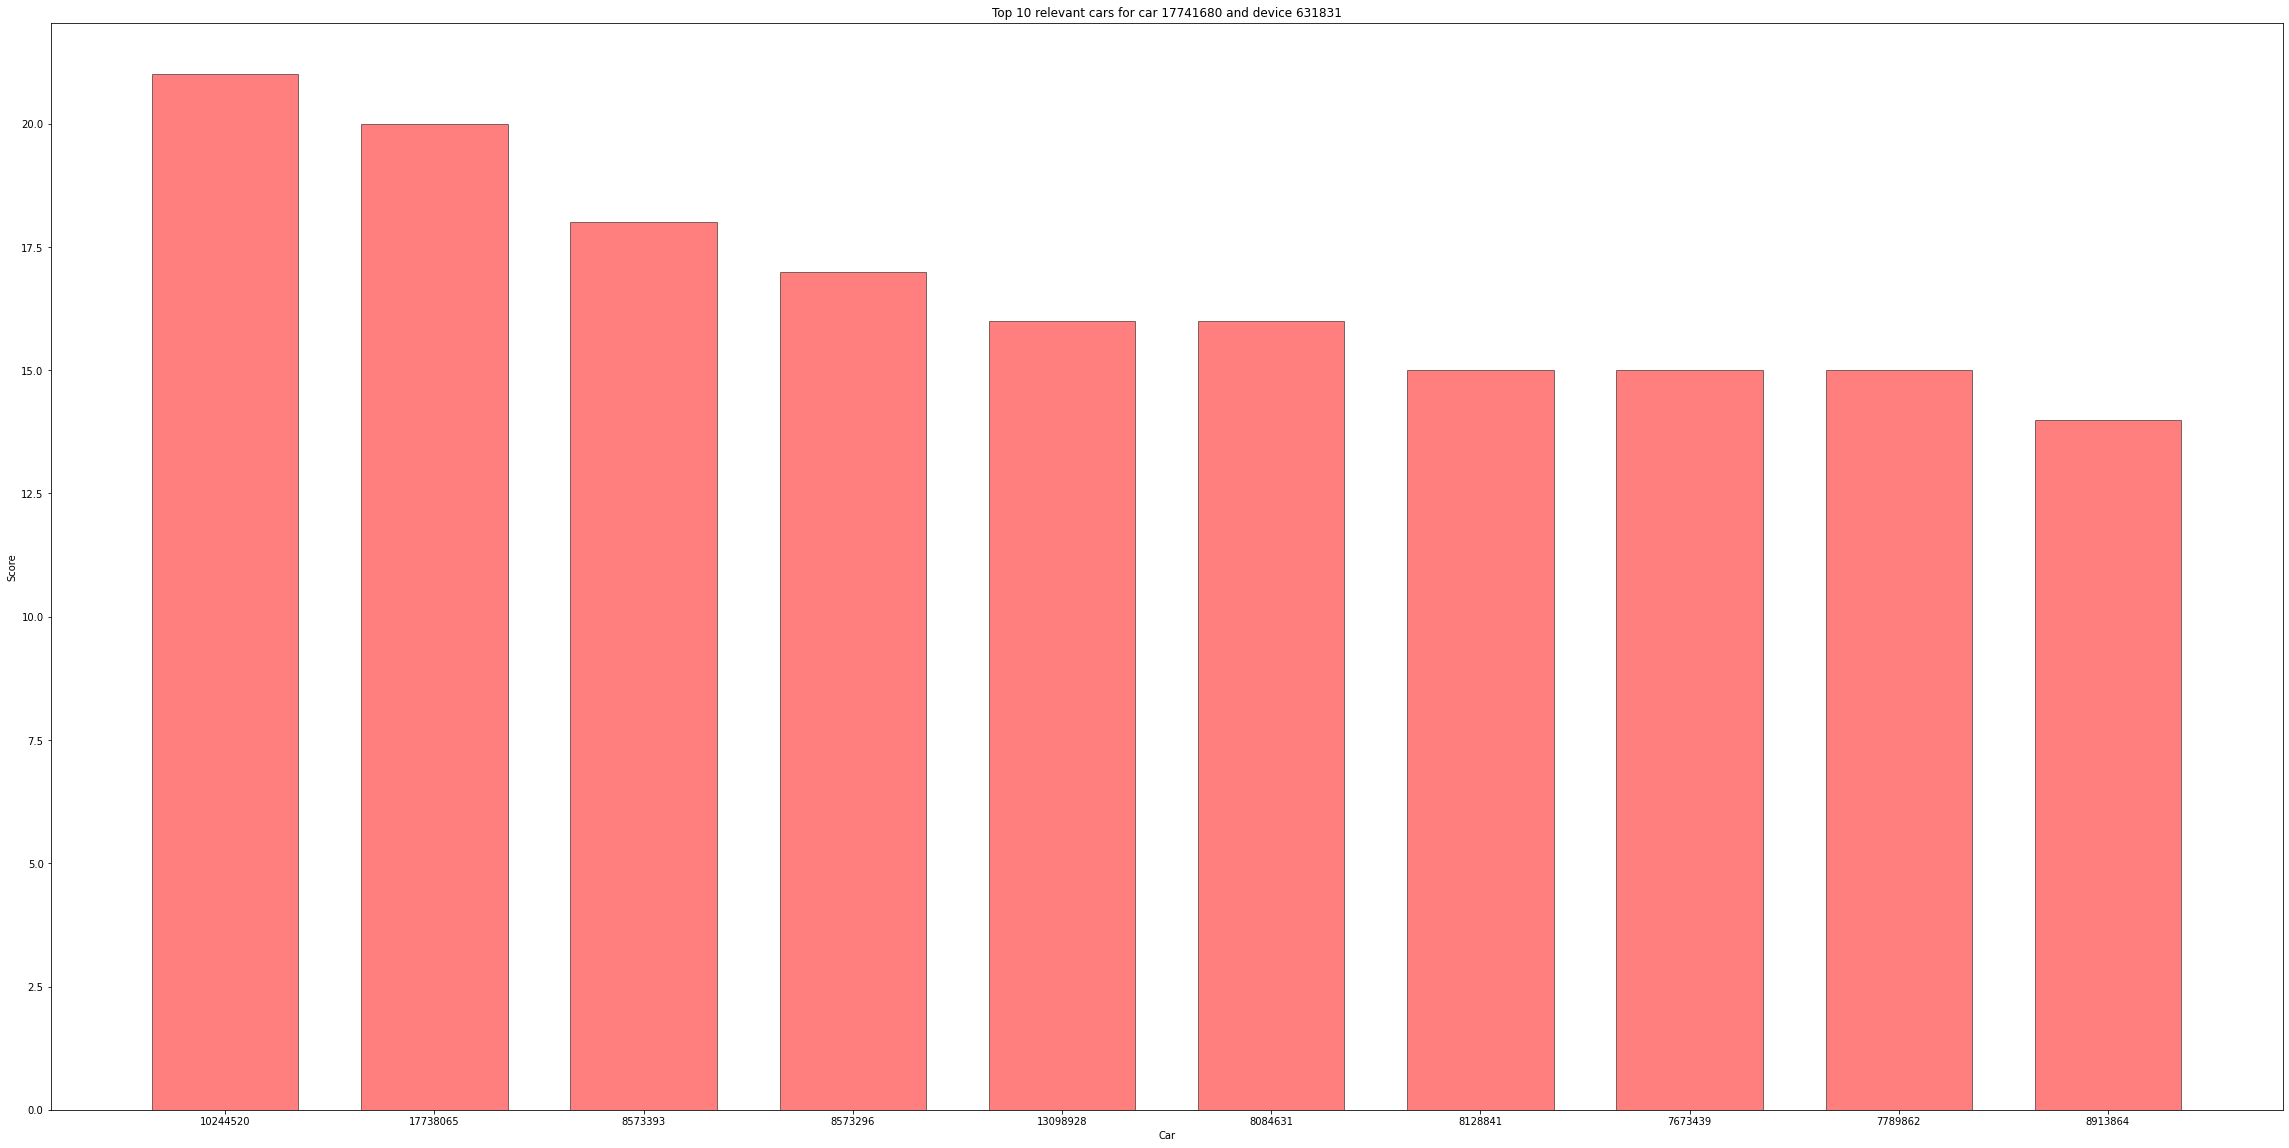

In [ ]:
plot_bar(top_k_cars, "Top 10 relevant cars for car " +
         query_car + " and device " + str(query_device), "Car", "Score", color='red')

In [ ]:
# in a for loop, run pixie algorithm for each day of the week and each hour of the day

random_query = car_device_hour_rdd.takeSample(False, 1)[0]
query_car = random_query[0]
query_device = random_query[1]


weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]


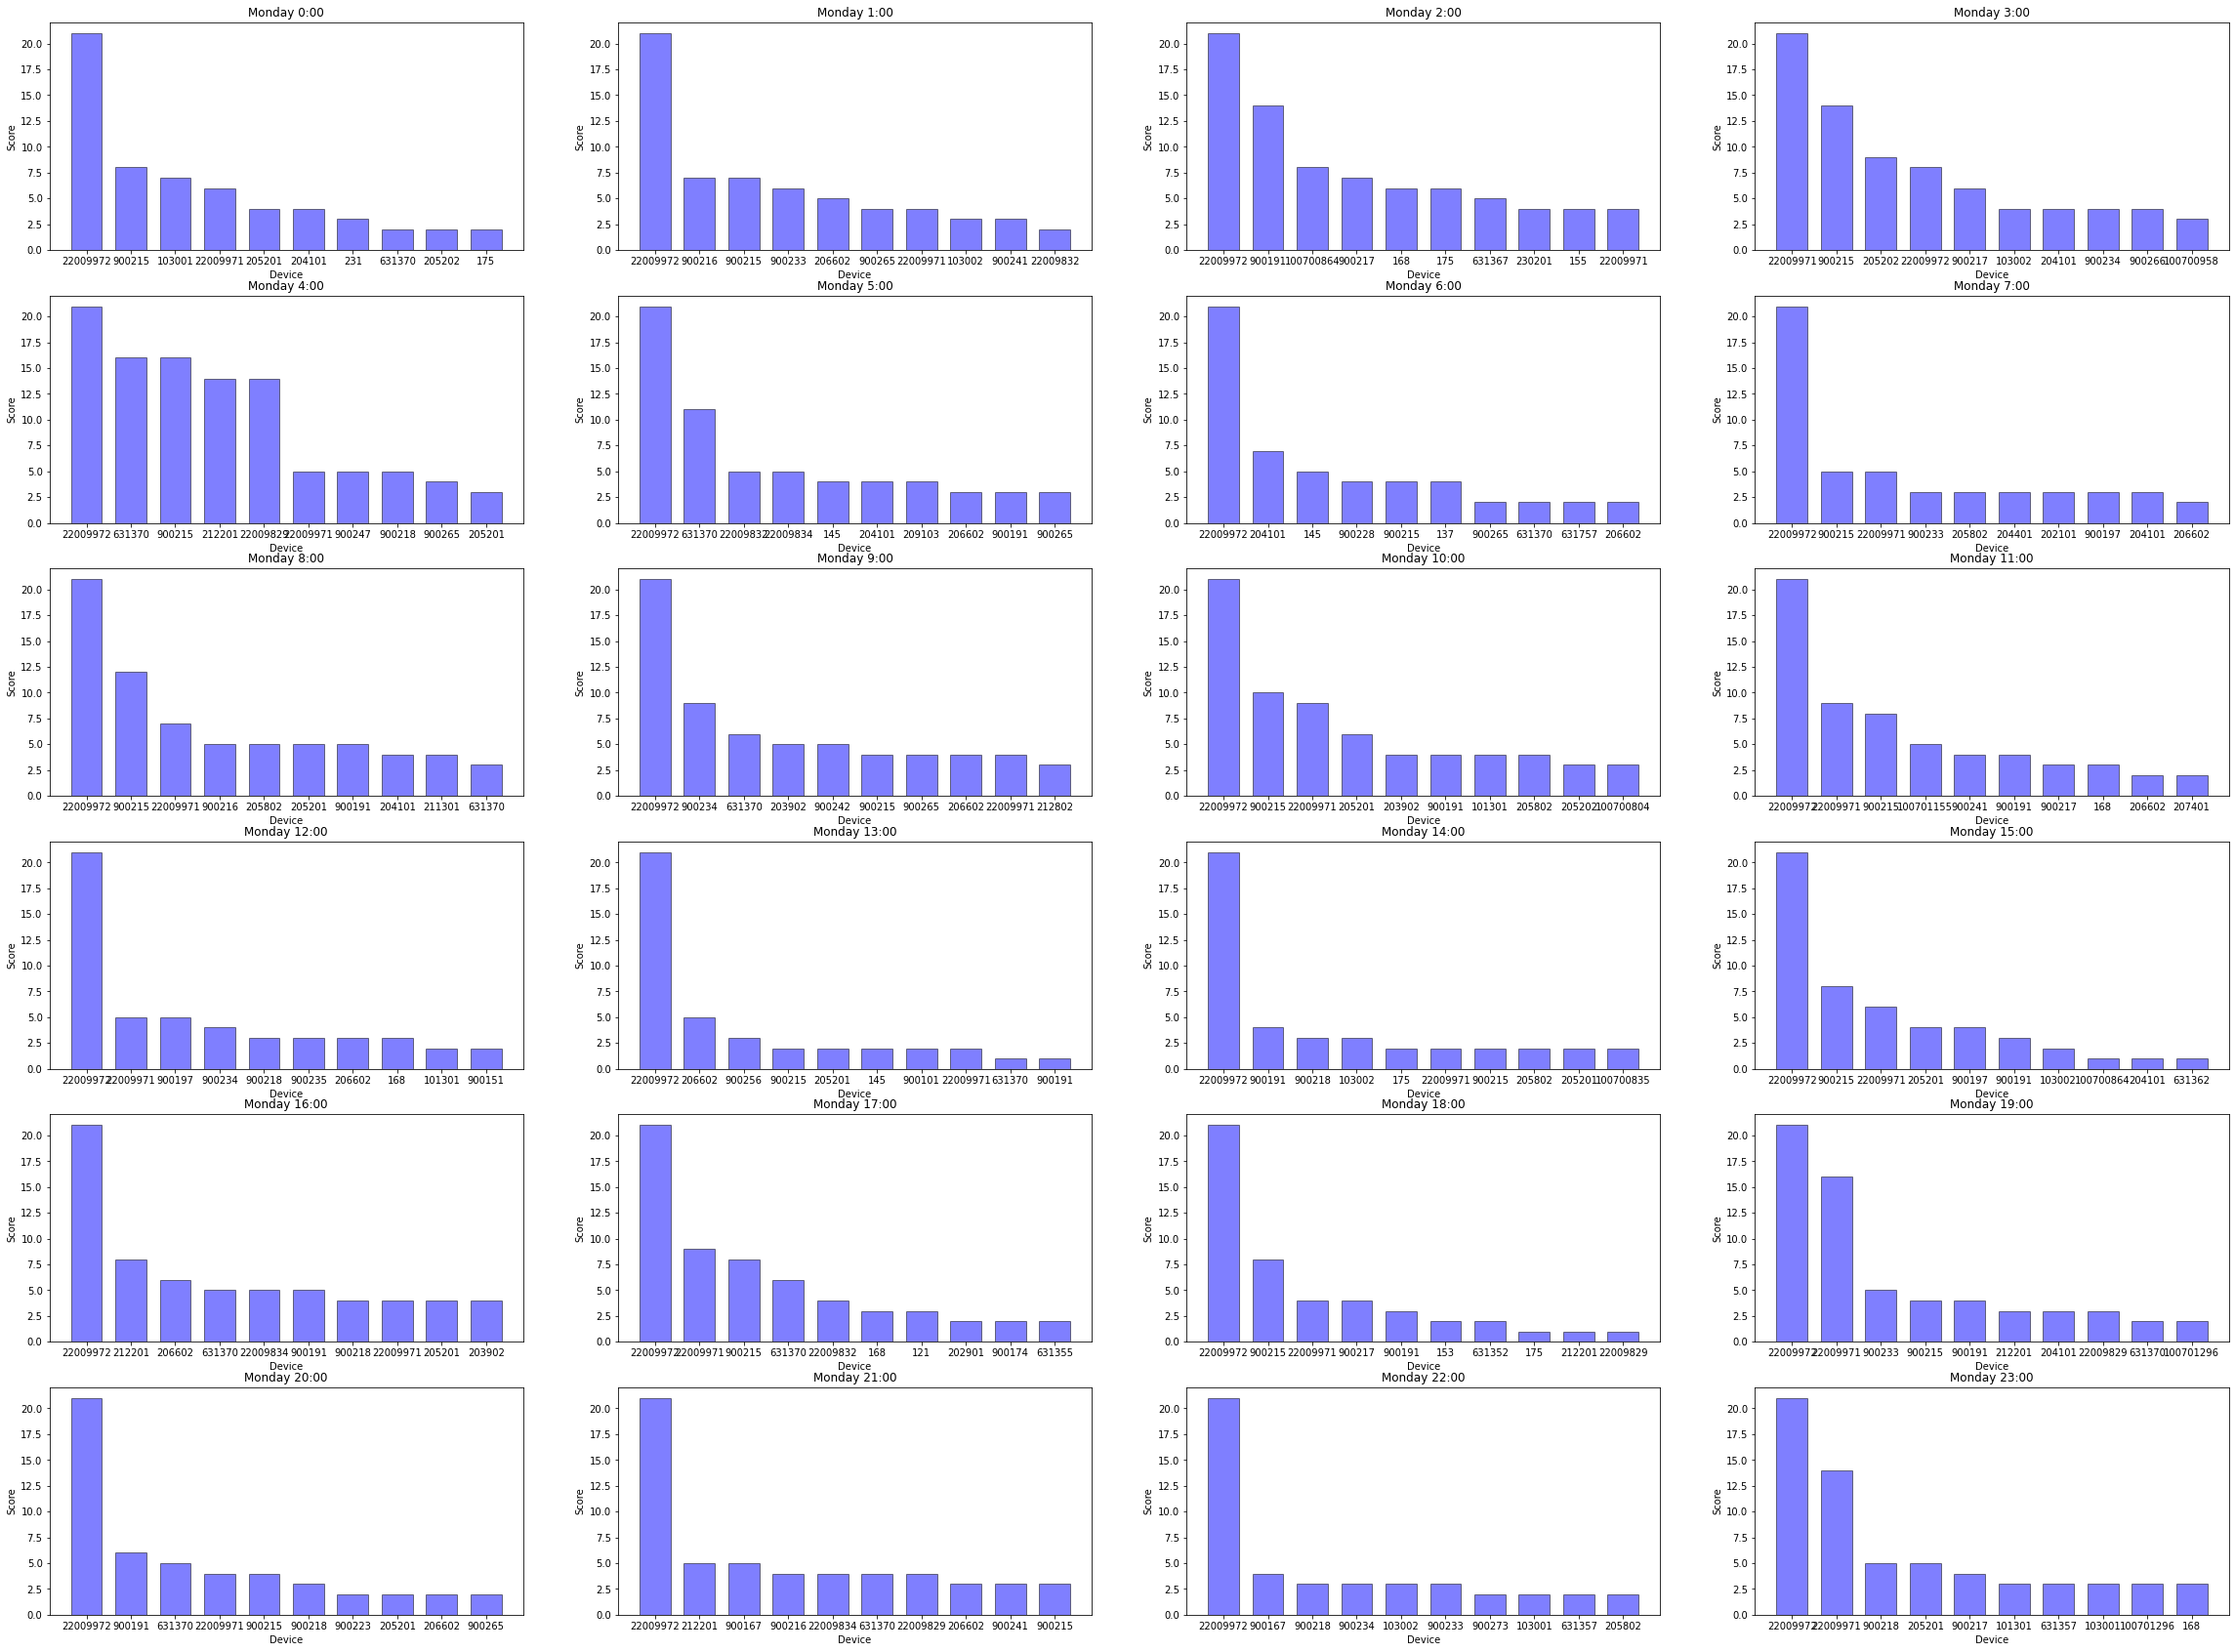

In [129]:
fig, axes = plt.subplots(6, 4, figsize=(40, 30))

for i in range(6):
    for j in range(4):
        relevant_devices = pixie_device_with_hour(i * 4 + j, query_device, query_car)
        top_k_devices = get_top_k(relevant_devices, 10)
        axes[i][j].set_title(weekdays[0] + " " + str(i * 4 + j) + ":00")
        axes[i][j].bar(np.arange(len(top_k_devices)), [x[1] for x in top_k_devices], 
        align="center", alpha=0.5, color='blue', edgecolor="black", linewidth=1, width=0.7)
        axes[i][j].set_xticks(np.arange(len(top_k_devices)))
        axes[i][j].set_xticklabels([x[0] for x in top_k_devices])
        axes[i][j].set_xlabel("Device")
        axes[i][j].set_ylabel("Score")